# <font color='blue'>Problema de Machine Learning de Regressão: Previsão de tráfego futuro</font>

# 1 - Definindo o problema de negócio

### Este conjunto de dados inclui informações sobre o volume de tráfego em determinadas estradas ao longo do tempo, juntamente com características como clima e feriados, e o objetivo é prever o volume de tráfego futuro.

# 2 - Decisões

### O problema de negócio já informa que é requerido um modelo de Machine Learning. No dataset, temos a coluna “traffic_volume” que é a variável que queremos prever. Desta forma, iremos utilizar aprendizagem supervisionada.

# 3 - Versão python e import dos pacotes utilizados

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
#!pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
#!pip install -q -U watermark

In [3]:
#!pip install keras==2.13.1
#!pip install tensorflow==2.13.0
#!pip install --upgrade tensorflow

In [4]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import sklearn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import LabelEncoder
from pmdarima.arima import auto_arima
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Danilo Temerloglou de Abreu" --iversions

Author: Danilo Temerloglou de Abreu

pandas    : 1.3.4
seaborn   : 0.12.2
sklearn   : 1.2.1
matplotlib: 3.7.1
numpy     : 1.23.5
tensorflow: 2.16.1



# 4 - Dicionário de dados

In [6]:
#holiday - Feriados nacionais dos USA mais feriados regionais, Feira Estadual de Minnesota
#temp - Temperatura média em Kelvin
#rain_1h - Quantidade em mm de chuva que ocorreu na hora
#snow_1h - Quantidade em mm de neve que ocorreu na hora
#clouds_all - Porcentagem de cobertura de nuvens
#weather_main - Breve descrição textual do clima atual
#weather_description - Descrição textual mais longa do clima atual
#date_time - Hora dos dados coletados no horário local CST
#traffic_volume - Volume de tráfego no sentido oeste relatado por hora I-94 ATR 301

# 5 - Carregando o Conjunto de dados

In [7]:
# Carrega o dataset
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

# 6 - EDA Análise Exploratória de Dados

In [8]:
# Shape
df.shape

(48204, 9)

In [9]:
#nomes das colunas
df.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume'],
      dtype='object')

In [10]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [11]:
# Amostra
df.sample(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
42418,None,268.69,0.0,0.0,1,Clear,sky is clear,2018-03-18 04:00:00,321
39627,None,266.50,0.0,0.0,75,Snow,light snow,2017-12-09 12:00:00,5263
7169,None,295.20,0.0,0.0,90,Thunderstorm,proximity thunderstorm with rain,2013-06-24 05:00:00,2937
17206,None,292.53,0.0,0.0,90,Clouds,overcast clouds,2015-08-08 08:00:00,2549
42838,None,266.61,0.0,0.0,1,Clear,sky is clear,2018-04-02 04:00:00,807


### Exploração das variáveis numéricas

In [12]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


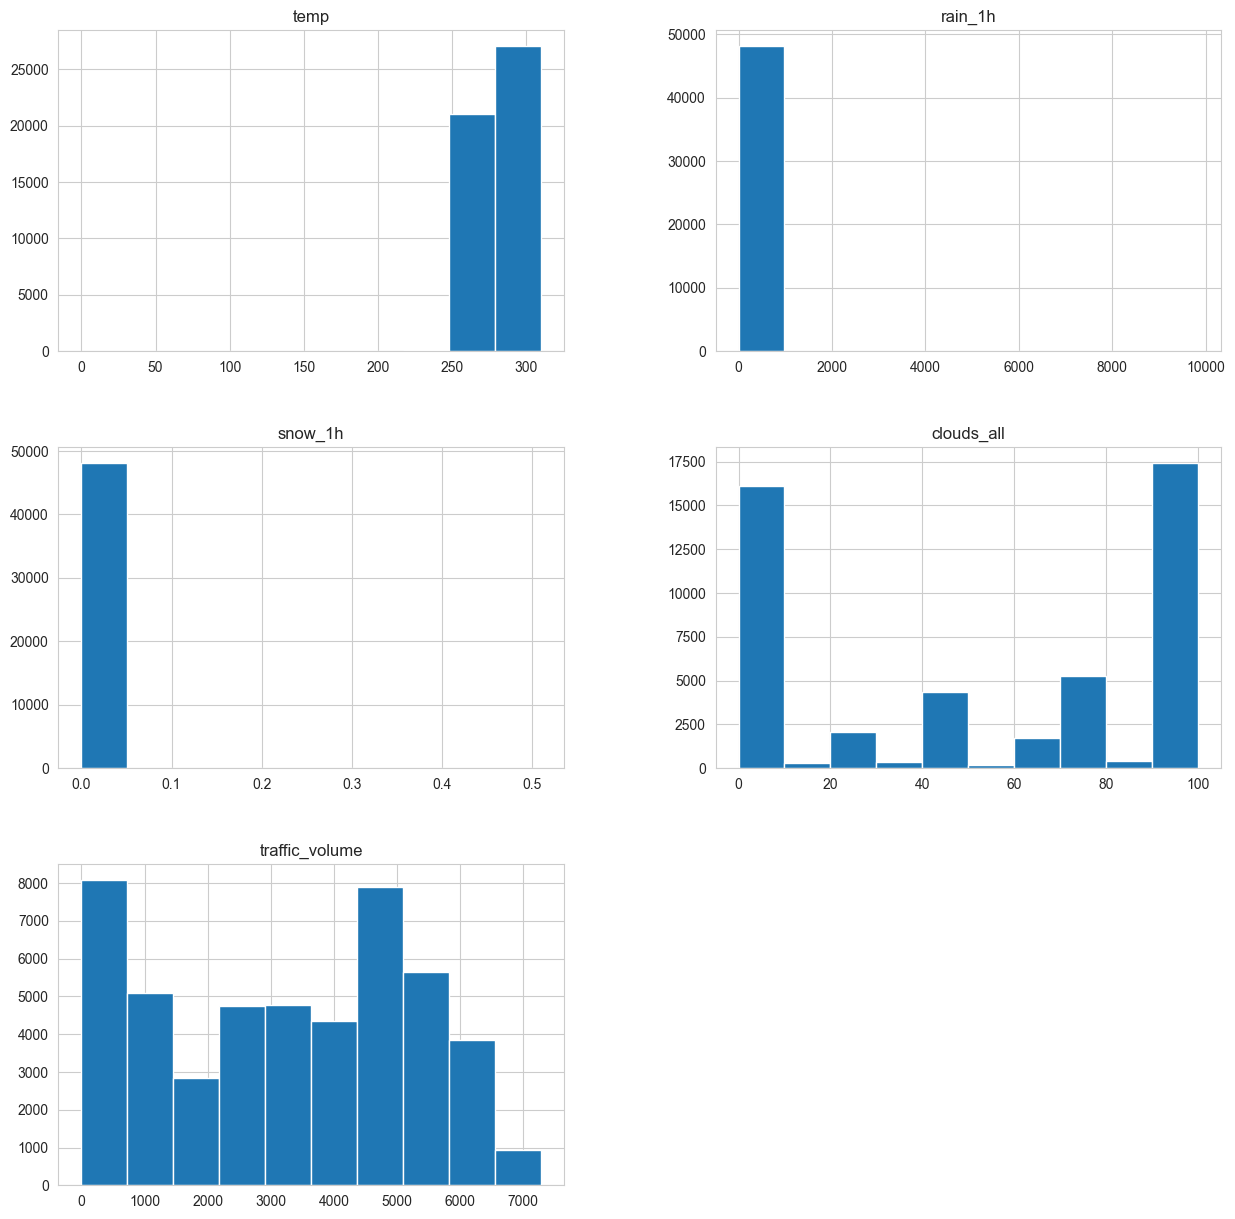

In [13]:
# Plot 
df.hist(figsize = (15,15), bins = 10) 
plt.show()

In [14]:
# Insighs:
# temperaturas concentram-se de 250 a 300K = -23 a 26 °C
# média baixa de chuva e de neve durante 1 hora 
# maioria dos dados está com tempo aberto ou nublado
# volume de tráfego está com boa variedade de valores


In [15]:
# Correlação (tabela)
df.corr()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
temp,1.000000,0.009069,-0.019755,-0.101976,0.130299
rain_1h,0.009069,1.000000,-0.000090,0.004818,0.004714
snow_1h,-0.019755,-0.000090,1.000000,0.027931,0.000733
clouds_all,-0.101976,0.004818,0.027931,1.000000,0.067054
traffic_volume,0.130299,0.004714,0.000733,0.067054,1.000000


In [16]:
#A variável traffic_volume (que é a que queremos prever) tem baixa correlação com as variáveis numéricas
# As variáveis preditoras numéricas tem baixa correlação entre si o que é bom para o modelo de ML.

### Exploração das variáveis categóricas

In [17]:
df['holiday'].value_counts() 

None                         48143
Labor Day                        7
Thanksgiving Day                 6
Christmas Day                    6
New Years Day                    6
Martin Luther King Jr Day        6
Columbus Day                     5
Veterans Day                     5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Name: holiday, dtype: int64

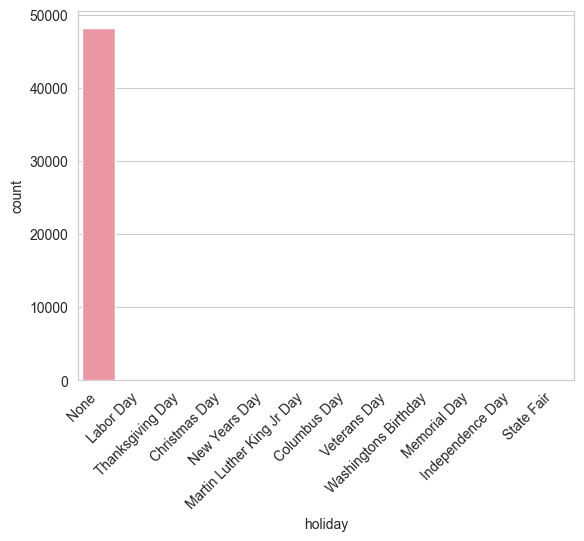

In [18]:
ax = sns.countplot(data=df, x='holiday', order=df['holiday'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

In [19]:
quantidade_de_categorias_holiday = df['holiday'].nunique()
print("Quantidade de categorias de feriados:", quantidade_de_categorias_holiday)

Quantidade de categorias de feriados: 12


In [20]:
# grande maioria de dias não é feriado

In [21]:
df['weather_main'].value_counts()

Clouds          15164
Clear           13391
Mist             5950
Rain             5672
Snow             2876
Drizzle          1821
Haze             1360
Thunderstorm     1034
Fog               912
Smoke              20
Squall              4
Name: weather_main, dtype: int64

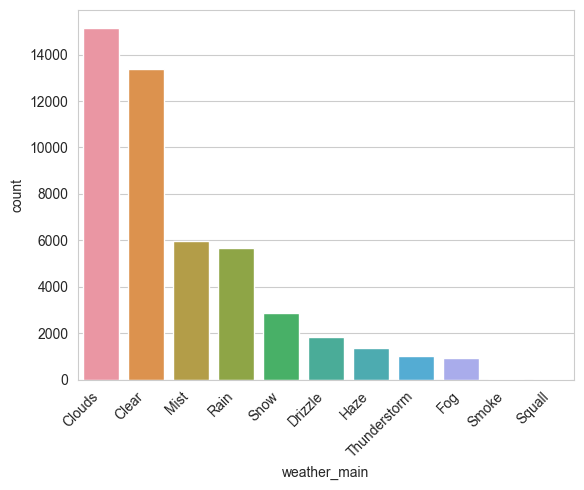

In [22]:
ax = sns.countplot(data=df, x='weather_main', order=df['weather_main'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

In [23]:
# maioria dos dados está com tempo aberto ou nublado

In [24]:
quantidade_de_categorias_weather_main = df['weather_main'].nunique()
print("Quantidade de categorias de tempo_resumo:", quantidade_de_categorias_weather_main)

Quantidade de categorias de tempo_resumo: 11


In [25]:
df['weather_description'].value_counts()

sky is clear                           11665
mist                                    5950
overcast clouds                         5081
broken clouds                           4666
scattered clouds                        3461
light rain                              3372
few clouds                              1956
light snow                              1946
Sky is Clear                            1726
moderate rain                           1664
haze                                    1360
light intensity drizzle                 1100
fog                                      912
proximity thunderstorm                   673
drizzle                                  651
heavy snow                               616
heavy intensity rain                     467
snow                                     293
proximity shower rain                    136
thunderstorm                             125
heavy intensity drizzle                   64
thunderstorm with heavy rain              63
thundersto

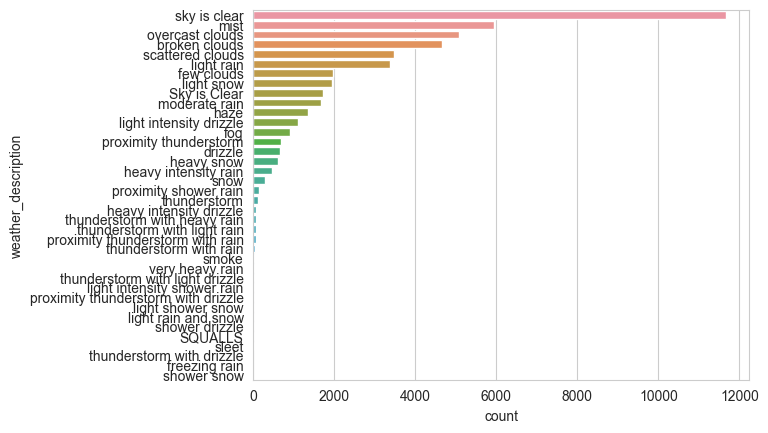

In [26]:
ax = sns.countplot(data=df, y='weather_description', orient='h', order=df['weather_description'].value_counts().index)
plt.show()

In [27]:
# maioria dos dados está com tempo aberto ou nublado

In [28]:
quantidade_de_categorias_weather_description = df['weather_description'].nunique()
print("Quantidade de categorias de tempo_resumo:", quantidade_de_categorias_weather_description)

Quantidade de categorias de tempo_resumo: 38


### Tratando a variável date_time

In [29]:
#converte variável date_time para tipo datetime
df['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')

In [30]:
#verifica tipo
df['date_time'].dtypes

dtype('<M8[ns]')

In [31]:
#cria duas variáveis 'data' e 'hora'
df['data'] = df['date_time'].dt.date
df['hora_completa'] = df['date_time'].dt.time
#exclui a coluna 'date_time'
df = df.drop(columns=['date_time'])

In [32]:
df.sample(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,data,hora_completa
29636,None,266.51,0.00,0.0,1,Clear,sky is clear,4034,2016-12-31,10:00:00
10525,None,260.50,0.25,0.0,64,Snow,light snow,2926,2013-12-08,20:00:00
11951,None,0.00,0.00,0.0,0,Clear,sky is clear,1670,2014-02-02,08:00:00
36382,None,288.01,0.00,0.0,1,Clear,sky is clear,2783,2017-08-18,05:00:00
43185,None,277.15,0.00,0.0,90,Rain,light rain,5330,2018-04-13,14:00:00


In [33]:
print(df.dtypes)

holiday                 object
temp                   float64
rain_1h                float64
snow_1h                float64
clouds_all               int64
weather_main            object
weather_description     object
traffic_volume           int64
data                    object
hora_completa           object
dtype: object


In [34]:
df.shape

(48204, 10)

In [35]:
#converte a data e obriga o que estiver em formato errado a ficar como NaT (not a Time)
df['data'] = pd.to_datetime(df['data'], errors='coerce')
# Exclua as linhas com valores NaT na coluna 'data' e 'hora'
df = df.dropna(subset=['data'])

In [36]:
df.shape

(48204, 10)

In [37]:
df.sample(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,data,hora_completa
1344,None,273.99,0.0,0.0,1,Mist,mist,2489,2012-11-21,05:00:00
16968,None,292.84,0.0,0.0,1,Clear,sky is clear,418,2015-07-30,01:00:00
33320,None,280.65,0.0,0.0,75,Clouds,broken clouds,466,2017-05-03,01:00:00
33408,None,292.46,0.0,0.0,40,Clouds,scattered clouds,4545,2017-05-06,17:00:00
6324,None,280.66,0.0,0.0,90,Mist,mist,6717,2013-05-23,07:00:00


In [38]:
#problemas de formato na coluna 'hora_completa'
print(df['hora_completa'].unique())

[datetime.time(9, 0) datetime.time(10, 0) datetime.time(11, 0)
 datetime.time(12, 0) datetime.time(13, 0) datetime.time(14, 0)
 datetime.time(15, 0) datetime.time(16, 0) datetime.time(17, 0)
 datetime.time(18, 0) datetime.time(19, 0) datetime.time(20, 0)
 datetime.time(21, 0) datetime.time(22, 0) datetime.time(23, 0)
 datetime.time(0, 0) datetime.time(1, 0) datetime.time(2, 0)
 datetime.time(3, 0) datetime.time(4, 0) datetime.time(5, 0)
 datetime.time(6, 0) datetime.time(8, 0) datetime.time(7, 0)]


In [39]:
# Converte a coluna de datetime.time para uma string formatada
df['hora_completa'] = df['hora_completa'].astype(str)
# Extrai os dois primeiros dígitos de cada valor na coluna
df['apenas_hora'] = df['hora_completa'].str[:2]

In [40]:
df.shape

(48204, 11)

In [41]:
df.sample(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,data,hora_completa,apenas_hora
35202,None,298.29,0.0,0.0,75,Thunderstorm,proximity thunderstorm,4330,2017-07-09,14:00:00,14
44776,None,291.15,0.0,0.0,1,Rain,moderate rain,2793,2018-06-08,05:00:00,05
48014,None,296.90,0.0,0.0,40,Clouds,scattered clouds,4117,2018-09-23,17:00:00,17
342,None,288.86,0.0,0.0,75,Clouds,broken clouds,6429,2012-10-16,17:00:00,17
33753,None,284.79,0.0,0.0,90,Rain,heavy intensity rain,353,2017-05-18,01:00:00,01


In [42]:
#exclui a coluna 'hora_completa'
df = df.drop(columns=['hora_completa'])

In [43]:
df.sample(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,data,apenas_hora
32973,None,287.69,0.00,0.0,1,Clear,sky is clear,4907,2017-04-23,12
7036,None,292.85,1.52,0.0,88,Rain,moderate rain,3882,2013-06-16,17
23430,None,280.01,0.00,0.0,1,Clear,sky is clear,588,2016-05-18,00
33177,None,285.48,0.00,0.0,1,Clear,sky is clear,4874,2017-04-29,16
34947,None,295.77,0.00,0.0,90,Clouds,overcast clouds,6490,2017-06-29,16


In [44]:
#alterar a coluna 'data' para formato 'dia-mês-ano'
df['data'] = df['data'].dt.strftime('%d-%m-%Y')

In [45]:
df.sample(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,data,apenas_hora
23585,None,290.99,0.0,0.0,40,Thunderstorm,proximity thunderstorm,3058,24-05-2016,05
41872,None,270.00,0.0,0.0,20,Clouds,few clouds,4472,26-02-2018,10
45508,None,301.65,0.0,0.0,40,Clouds,scattered clouds,4728,02-07-2018,14
5794,None,281.05,0.0,0.0,90,Clouds,overcast clouds,3420,05-05-2013,19
19374,None,278.15,0.0,0.0,5,Clear,sky is clear,2181,08-11-2015,08


In [46]:
#mudando 'data' para tipo 'datetime'
df['data'] = pd.to_datetime(df['data'])
#criando as variáveis 'dia','mes','ano'
df['dia'] = df['data'].dt.day
df['mes'] = df['data'].dt.month
df['ano'] = df['data'].dt.year

In [47]:
print(df.dtypes)

holiday                        object
temp                          float64
rain_1h                       float64
snow_1h                       float64
clouds_all                      int64
weather_main                   object
weather_description            object
traffic_volume                  int64
data                   datetime64[ns]
apenas_hora                    object
dia                             int64
mes                             int64
ano                             int64
dtype: object


In [48]:
df.sample(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,data,apenas_hora,dia,mes,ano
8212,None,290.16,0.00,0.0,92,Clouds,overcast clouds,1818,2013-05-08,22,8,5,2013
5868,None,293.30,0.00,0.0,40,Clouds,scattered clouds,2562,2013-08-05,21,5,8,2013
18350,None,295.86,1.52,0.0,90,Rain,moderate rain,5182,2015-09-17,14,17,9,2015
10320,None,274.59,0.00,0.0,64,Drizzle,drizzle,2137,2013-02-12,22,12,2,2013
25544,None,291.19,0.00,0.0,0,Clear,Sky is Clear,3069,2016-06-08,22,8,6,2016


In [49]:
# Ordene o DataFrame por dia, mês e ano ao mesmo tempo em ordem crescente
df = df.sort_values(by=['ano', 'mes', 'dia','apenas_hora'])

# Se desejar, você pode redefinir o índice do DataFrame após a ordenação
df = df.reset_index(drop=True)

In [50]:
df.head(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,data,apenas_hora,dia,mes,ano
0,None,271.73,0.0,0.0,1,Clear,sky is clear,716,2012-01-11,00,11,1,2012
1,None,270.91,0.0,0.0,1,Clear,sky is clear,453,2012-01-11,01,11,1,2012
2,None,270.15,0.0,0.0,1,Clear,sky is clear,324,2012-01-11,02,11,1,2012
3,None,269.68,0.0,0.0,1,Clear,sky is clear,390,2012-01-11,03,11,1,2012
4,None,269.44,0.0,0.0,1,Clear,sky is clear,775,2012-01-11,04,11,1,2012


In [51]:
colunas_para_manter = [col for col in df.columns if col not in ['apenas_hora', 'traffic_volume']]
# Reorganizando a ordem das colunas 
df = df[colunas_para_manter + ['apenas_hora', 'traffic_volume']]

In [52]:
#mudando a coluna 'apenas_hora' para tipo int
df['apenas_hora'] = df['apenas_hora'].astype(int)

In [53]:
df.sample(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,data,dia,mes,ano,apenas_hora,traffic_volume
27822,None,256.65,0.00,0.0,90,Haze,haze,2016-11-01,1,11,2016,22,1215
22424,None,295.68,0.28,0.0,92,Rain,light rain,2016-04-08,8,4,2016,11,4517
12608,None,272.28,0.00,0.0,75,Clouds,broken clouds,2014-03-18,18,3,2014,2,290
7253,None,280.67,0.00,0.0,36,Clouds,scattered clouds,2013-07-10,10,7,2013,9,4925
4478,None,267.88,0.00,0.0,40,Clouds,scattered clouds,2013-03-28,28,3,2013,7,6780


In [54]:
# Ordene o DataFrame por dia, mês e ano ao mesmo tempo em ordem crescente
df = df.sort_values(by=['ano', 'mes', 'dia','apenas_hora'])

# Se desejar, você pode redefinir o índice do DataFrame após a ordenação
df = df.reset_index(drop=True)

In [55]:
df.head(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,data,dia,mes,ano,apenas_hora,traffic_volume
0,None,271.73,0.0,0.0,1,Clear,sky is clear,2012-01-11,11,1,2012,0,716
1,None,270.91,0.0,0.0,1,Clear,sky is clear,2012-01-11,11,1,2012,1,453
2,None,270.15,0.0,0.0,1,Clear,sky is clear,2012-01-11,11,1,2012,2,324
3,None,269.68,0.0,0.0,1,Clear,sky is clear,2012-01-11,11,1,2012,3,390
4,None,269.44,0.0,0.0,1,Clear,sky is clear,2012-01-11,11,1,2012,4,775
5,None,268.96,0.0,0.0,1,Clear,sky is clear,2012-01-11,11,1,2012,5,2572
6,None,268.61,0.0,0.0,1,Clear,sky is clear,2012-01-11,11,1,2012,6,5595
7,None,268.74,0.0,0.0,1,Clear,sky is clear,2012-01-11,11,1,2012,7,6852
8,None,268.45,0.0,0.0,20,Clouds,few clouds,2012-01-11,11,1,2012,8,5892
9,None,270.90,0.0,0.0,1,Clear,sky is clear,2012-01-11,11,1,2012,9,5327


In [56]:
#até aqui tenho o dataset df faltando tratar as variáveis categóricas holiday, weather_main, weather_description

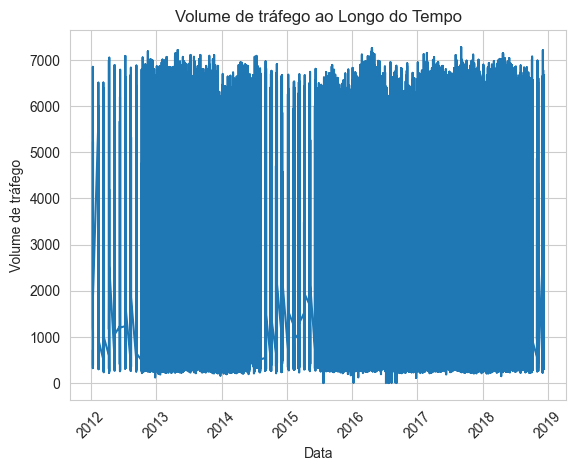

In [57]:
#gráfico da variável target que é o 'traffic_volume'
plt.plot(df['data'], df['traffic_volume'])

# Rotule os eixos
plt.xlabel('Data')
plt.ylabel('Volume de tráfego')

# Adicione um título ao gráfico
plt.title('Volume de tráfego ao Longo do Tempo')

# Rotacione os rótulos do eixo x para torná-los mais legíveis, se necessário
plt.xticks(rotation=45)

# Mostre o gráfico
plt.show()

In [58]:
#visualização ficou muito ruim
#vamos agrupar os dados por mês e ano para melhorar a visualização

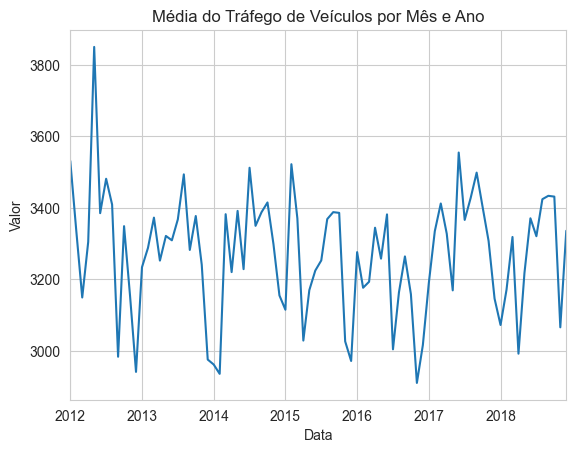

In [59]:
# Crie uma coluna de data concatenando 'ano' e 'mes'
df['mes_ano'] = pd.to_datetime(df['mes'].astype(str) + '-' + df['ano'].astype(str), format='%m-%Y')

# Agrupe os dados pela nova coluna de data e aplique a função de agregação desejada
dados_agrupados = df.groupby('mes_ano')['traffic_volume'].mean()  # Por exemplo, calculando a média da coluna 'traffic_volume'

# Plotar os dados agrupados
dados_agrupados.plot(kind='line', xlabel='Data', ylabel='Valor', title='Média do Tráfego de Veículos por Mês e Ano')
plt.show()

In [60]:
#vamos que de 2013 a 2019 ocorre uma sazonalidade sendo o meio do ano o período em que tem mais movimento de veículos

### Verificando a relação entre atributos

Text(0, 0.5, 'dados_agrupados_volume_trafego')

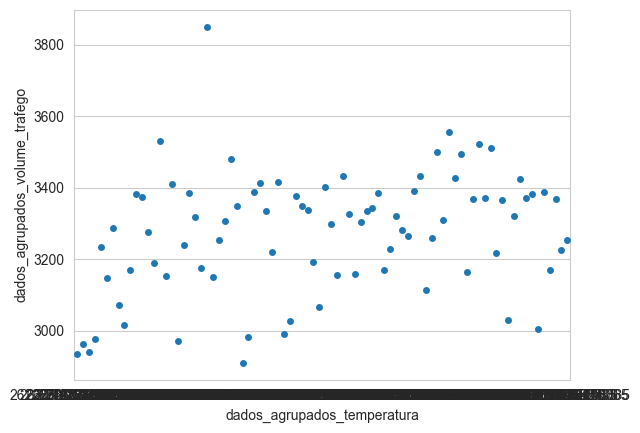

In [61]:
# Agrupe os dados pela nova coluna de data e aplique a função de agregação desejada
dados_agrupados_temp = df.groupby('mes_ano')['temp'].mean()
# Plotar os dados agrupados
sns.stripplot(data=df, x=dados_agrupados_temp, y=dados_agrupados, jitter=True)
plt.xlabel('dados_agrupados_temperatura')
plt.ylabel('dados_agrupados_volume_trafego')

### Observando o gráfico de dispersão verificamos que não há correlação entre a temperatura e o volume de tráfego.

## 7 - Pré-Processamento de Dados Para Construção de Modelos de Machine Learning

In [62]:
df.shape

(48204, 14)

In [63]:
# Verificando valores ausentes
numero_ausentes = df.isnull().sum()
print('A quantidade de valores ausentes em cada coluna é:\n', numero_ausentes)

A quantidade de valores ausentes em cada coluna é:
 holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
data                   0
dia                    0
mes                    0
ano                    0
apenas_hora            0
traffic_volume         0
mes_ano                0
dtype: int64


In [64]:
# Verifica registros duplicados (remove uma das duplicatas)
numero_duplicados = df.duplicated().sum()
print('A quantidade de valores duplicados é: ', numero_duplicados)

A quantidade de valores duplicados é:  17


In [65]:
#remove valores duplicados
df = df.drop_duplicates()

## Tratamento de outliers

<Axes: >

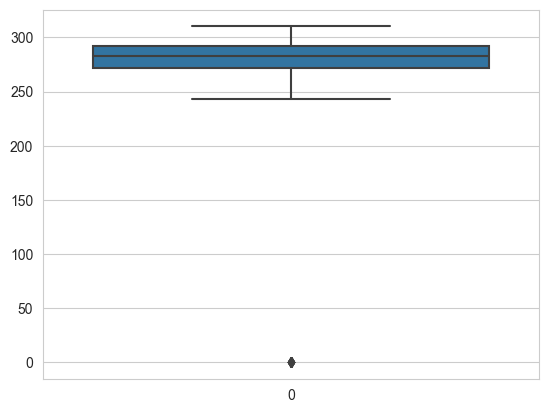

In [66]:
# Boxplot
sns.boxplot(df.temp)

<Axes: >

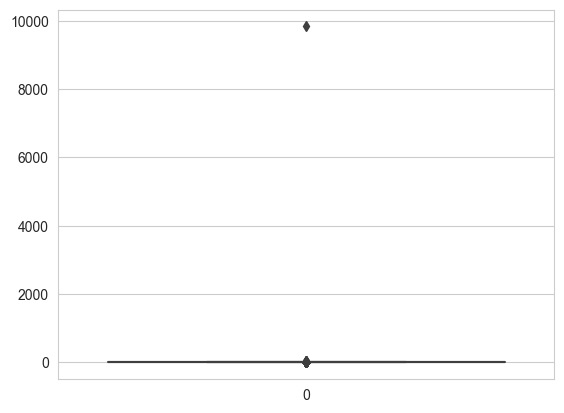

In [67]:
# Boxplot
sns.boxplot(df.rain_1h)

<Axes: >

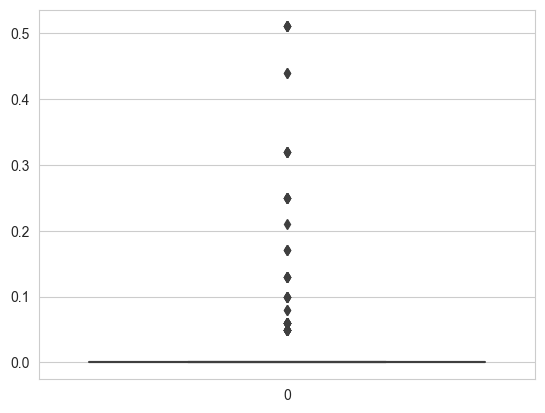

In [68]:
# Boxplot
sns.boxplot(df.snow_1h)

<Axes: >

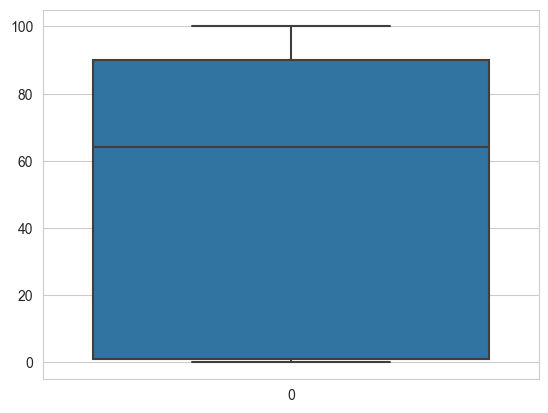

In [69]:
# Boxplot
sns.boxplot(df.clouds_all)

<Axes: >

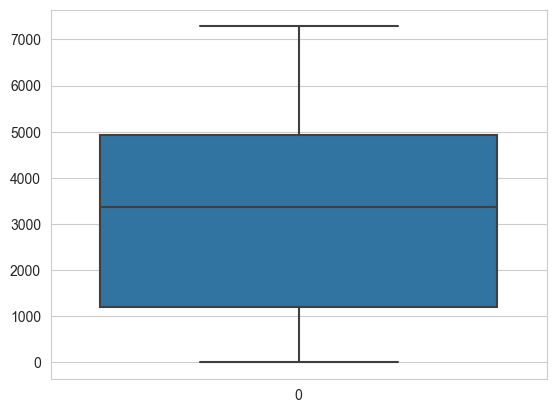

In [70]:
# Boxplot
sns.boxplot(df.traffic_volume)

In [71]:
#outliers - variável temp 
# Calcular os quartis
Q1 = df['temp'].quantile(0.25)
Q3 = df['temp'].quantile(0.75)

# Calcular o intervalo interquartil (IQR)
IQR = Q3 - Q1

# Definir limites para identificar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Identificar outliers
outliers_inferiores = df[df['temp'] < limite_inferior]
outliers_superiores = df[df['temp'] > limite_superior]

# Contar a quantidade de outliers inferiores e superiores
quantidade_outliers_inferiores = len(outliers_inferiores)
quantidade_outliers_superiores = len(outliers_superiores)

print("Quantidade de outliers inferiores:", quantidade_outliers_inferiores)
print("Quantidade de outliers superiores:", quantidade_outliers_superiores)

Quantidade de outliers inferiores: 10
Quantidade de outliers superiores: 0


In [72]:
# Decisão: Manter o outlier      

In [73]:
#outliers - variável rain_1h 
# Calcular os quartis
Q1 = df['rain_1h'].quantile(0.25)
Q3 = df['rain_1h'].quantile(0.75)

# Calcular o intervalo interquartil (IQR)
IQR = Q3 - Q1

# Definir limites para identificar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Identificar outliers
outliers_inferiores = df[df['rain_1h'] < limite_inferior]
outliers_superiores = df[df['rain_1h'] > limite_superior]

# Contar a quantidade de outliers inferiores e superiores
quantidade_outliers_inferiores = len(outliers_inferiores)
quantidade_outliers_superiores = len(outliers_superiores)

print("Quantidade de outliers inferiores:", quantidade_outliers_inferiores)
print("Quantidade de outliers superiores:", quantidade_outliers_superiores)

Quantidade de outliers inferiores: 0
Quantidade de outliers superiores: 3467


In [74]:
# Decisão: Manter o outlier   

In [75]:
#outliers - variável snow_1h 
# Calcular os quartis
Q1 = df['snow_1h'].quantile(0.25)
Q3 = df['snow_1h'].quantile(0.75)

# Calcular o intervalo interquartil (IQR)
IQR = Q3 - Q1

# Definir limites para identificar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Identificar outliers
outliers_inferiores = df[df['snow_1h'] < limite_inferior]
outliers_superiores = df[df['snow_1h'] > limite_superior]

# Contar a quantidade de outliers inferiores e superiores
quantidade_outliers_inferiores = len(outliers_inferiores)
quantidade_outliers_superiores = len(outliers_superiores)

print("Quantidade de outliers inferiores:", quantidade_outliers_inferiores)
print("Quantidade de outliers superiores:", quantidade_outliers_superiores)


Quantidade de outliers inferiores: 0
Quantidade de outliers superiores: 63


In [76]:
# Decisão: Manter o outlier  

In [77]:
#outliers - variável clouds_all
# Calcular os quartis
Q1 = df['clouds_all'].quantile(0.25)
Q3 = df['clouds_all'].quantile(0.75)

# Calcular o intervalo interquartil (IQR)
IQR = Q3 - Q1

# Definir limites para identificar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Identificar outliers
outliers_inferiores = df[df['clouds_all'] < limite_inferior]
outliers_superiores = df[df['clouds_all'] > limite_superior]

# Contar a quantidade de outliers inferiores e superiores
quantidade_outliers_inferiores = len(outliers_inferiores)
quantidade_outliers_superiores = len(outliers_superiores)

print("Quantidade de outliers inferiores:", quantidade_outliers_inferiores)
print("Quantidade de outliers superiores:", quantidade_outliers_superiores)


Quantidade de outliers inferiores: 0
Quantidade de outliers superiores: 0


In [78]:
 # Decisão: Manter. Não tem outliers.

In [79]:
#outliers - variável traffic_volume
# Calcular os quartis
Q1 = df['traffic_volume'].quantile(0.25)
Q3 = df['traffic_volume'].quantile(0.75)

# Calcular o intervalo interquartil (IQR)
IQR = Q3 - Q1

# Definir limites para identificar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Identificar outliers
outliers_inferiores = df[df['traffic_volume'] < limite_inferior]
outliers_superiores = df[df['traffic_volume'] > limite_superior]

# Contar a quantidade de outliers inferiores e superiores
quantidade_outliers_inferiores = len(outliers_inferiores)
quantidade_outliers_superiores = len(outliers_superiores)

print("Quantidade de outliers inferiores:", quantidade_outliers_inferiores)
print("Quantidade de outliers superiores:", quantidade_outliers_superiores)


Quantidade de outliers inferiores: 0
Quantidade de outliers superiores: 0


In [80]:
# Decisão:  Manter. Não tem outliers.

### Tratamento de variaveis categóricas

In [81]:
df.sample(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,data,dia,mes,ano,apenas_hora,traffic_volume,mes_ano
6420,None,276.70,0.0,0.0,90,Clouds,overcast clouds,2013-06-05,5,6,2013,4,732,2013-06-01
15297,None,264.63,0.0,0.0,64,Clouds,broken clouds,2014-09-01,1,9,2014,13,4839,2014-09-01
4556,None,277.34,0.0,0.0,90,Rain,moderate rain,2013-03-31,31,3,2013,6,650,2013-03-01
42029,None,299.48,0.0,0.0,90,Clouds,overcast clouds,2018-03-08,8,3,2018,19,3767,2018-03-01
15421,None,293.63,0.0,0.0,90,Clouds,overcast clouds,2014-09-06,6,9,2014,15,5740,2014-09-01


In [82]:
df['holiday'].value_counts()

None                         48126
Labor Day                        7
Thanksgiving Day                 6
Christmas Day                    6
New Years Day                    6
Martin Luther King Jr Day        6
Columbus Day                     5
Veterans Day                     5
Washingtons Birthday             5
Independence Day                 5
Memorial Day                     5
State Fair                       5
Name: holiday, dtype: int64

In [83]:
df['weather_main'].value_counts()

Clouds          15158
Clear           13384
Mist             5949
Rain             5672
Snow             2875
Drizzle          1820
Haze             1360
Thunderstorm     1033
Fog               912
Smoke              20
Squall              4
Name: weather_main, dtype: int64

In [84]:
df['weather_description'].value_counts()

sky is clear                           11659
mist                                    5949
overcast clouds                         5079
broken clouds                           4663
scattered clouds                        3460
light rain                              3372
few clouds                              1956
light snow                              1945
Sky is Clear                            1725
moderate rain                           1664
haze                                    1360
light intensity drizzle                 1099
fog                                      912
proximity thunderstorm                   673
drizzle                                  651
heavy snow                               616
heavy intensity rain                     467
snow                                     293
proximity shower rain                    136
thunderstorm                             124
heavy intensity drizzle                   64
thunderstorm with heavy rain              63
thundersto

In [85]:
#decisão - excluir a variável 'weather_description'
#exclui a coluna 'hora_completa'
df = df.drop(columns=['weather_description'])

In [86]:
df.sample(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,data,dia,mes,ano,apenas_hora,traffic_volume,mes_ano
9208,None,289.30,0.00,0.0,92,Mist,2013-10-06,6,10,2013,23,1175,2013-10-01
44444,None,286.08,2.79,0.0,1,Rain,2018-06-09,9,6,2018,0,570,2018-06-01
46064,None,299.95,0.00,0.0,75,Clouds,2018-08-14,14,8,2018,11,4741,2018-08-01
8593,None,302.57,0.00,0.0,0,Clear,2013-09-07,7,9,2013,16,6680,2013-09-01
10536,None,301.21,0.00,0.0,8,Clear,2013-12-07,7,12,2013,19,3569,2013-12-01


In [87]:
print(df.dtypes)

holiday                   object
temp                     float64
rain_1h                  float64
snow_1h                  float64
clouds_all                 int64
weather_main              object
data              datetime64[ns]
dia                        int64
mes                        int64
ano                        int64
apenas_hora                int32
traffic_volume             int64
mes_ano           datetime64[ns]
dtype: object


In [88]:
qtde_holiday = df['holiday'].nunique()
qtde_holiday

12

In [89]:
# Obter categorias únicas da coluna 'holiday'
cat_holiday = df['holiday'].unique()

# Criar um dicionário para mapear categorias para valores ordinais
mapeamento = {categoria : i+1 for i, categoria in enumerate(cat_holiday)}

# Aplicar o mapeamento à coluna 'holiday'
df['holiday'] = df['holiday'].map(mapeamento)

print(df)

       holiday    temp  rain_1h  snow_1h  clouds_all weather_main       data  \
0            1  271.73      0.0      0.0           1        Clear 2012-01-11   
1            1  270.91      0.0      0.0           1        Clear 2012-01-11   
2            1  270.15      0.0      0.0           1        Clear 2012-01-11   
3            1  269.68      0.0      0.0           1        Clear 2012-01-11   
4            1  269.44      0.0      0.0           1        Clear 2012-01-11   
...        ...     ...      ...      ...         ...          ...        ...   
48199        1  300.14      0.0      0.0          20       Clouds 2018-12-09   
48200        1  297.82      0.0      0.0           5        Clear 2018-12-09   
48201        1  296.10      0.0      0.0           5        Clear 2018-12-09   
48202        1  295.32      0.0      0.0           5        Clear 2018-12-09   
48203        1  294.46      0.0      0.0           1        Clear 2018-12-09   

       dia  mes   ano  apenas_hora  tra

In [90]:
qtde_weather_main = df['weather_main'].nunique()
qtde_weather_main

11

In [91]:
# Obter categorias únicas da coluna 'holiday'
cat_weather_main = df['weather_main'].unique()

# Criar um dicionário para mapear categorias para valores ordinais
mapeamento = {categoria : i+1 for i, categoria in enumerate(cat_weather_main)}

# Aplicar o mapeamento à coluna 'holiday'
df['weather_main'] = df['weather_main'].map(mapeamento)

print(df)

       holiday    temp  rain_1h  snow_1h  clouds_all  weather_main       data  \
0            1  271.73      0.0      0.0           1             1 2012-01-11   
1            1  270.91      0.0      0.0           1             1 2012-01-11   
2            1  270.15      0.0      0.0           1             1 2012-01-11   
3            1  269.68      0.0      0.0           1             1 2012-01-11   
4            1  269.44      0.0      0.0           1             1 2012-01-11   
...        ...     ...      ...      ...         ...           ...        ...   
48199        1  300.14      0.0      0.0          20             2 2018-12-09   
48200        1  297.82      0.0      0.0           5             1 2018-12-09   
48201        1  296.10      0.0      0.0           5             1 2018-12-09   
48202        1  295.32      0.0      0.0           5             1 2018-12-09   
48203        1  294.46      0.0      0.0           1             1 2018-12-09   

       dia  mes   ano  apen

In [92]:
#cria variáveis dummy para 'holiday' e 'weather_main'
#df = pd.get_dummies(df, columns=['holiday', 'weather_main'])

In [93]:
df.head(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,data,dia,mes,ano,apenas_hora,traffic_volume,mes_ano
0,1,271.73,0.0,0.0,1,1,2012-01-11,11,1,2012,0,716,2012-01-01
1,1,270.91,0.0,0.0,1,1,2012-01-11,11,1,2012,1,453,2012-01-01
2,1,270.15,0.0,0.0,1,1,2012-01-11,11,1,2012,2,324,2012-01-01
3,1,269.68,0.0,0.0,1,1,2012-01-11,11,1,2012,3,390,2012-01-01
4,1,269.44,0.0,0.0,1,1,2012-01-11,11,1,2012,4,775,2012-01-01


In [94]:
# Armazenar a coluna que queremos mover
coluna_a_mover = df.pop('traffic_volume')

# Anexar a coluna de volta ao final do DataFrame
df['traffic_volume'] = coluna_a_mover

In [95]:
df.head(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,data,dia,mes,ano,apenas_hora,mes_ano,traffic_volume
0,1,271.73,0.0,0.0,1,1,2012-01-11,11,1,2012,0,2012-01-01,716
1,1,270.91,0.0,0.0,1,1,2012-01-11,11,1,2012,1,2012-01-01,453
2,1,270.15,0.0,0.0,1,1,2012-01-11,11,1,2012,2,2012-01-01,324
3,1,269.68,0.0,0.0,1,1,2012-01-11,11,1,2012,3,2012-01-01,390
4,1,269.44,0.0,0.0,1,1,2012-01-11,11,1,2012,4,2012-01-01,775


In [96]:
df.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'data', 'dia', 'mes', 'ano', 'apenas_hora', 'mes_ano',
       'traffic_volume'],
      dtype='object')

In [97]:
df.shape

(48187, 13)

In [98]:
df.dtypes

holiday                    int64
temp                     float64
rain_1h                  float64
snow_1h                  float64
clouds_all                 int64
weather_main               int64
data              datetime64[ns]
dia                        int64
mes                        int64
ano                        int64
apenas_hora                int32
mes_ano           datetime64[ns]
traffic_volume             int64
dtype: object

In [99]:
df.sample(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,data,dia,mes,ano,apenas_hora,mes_ano,traffic_volume
22837,1,289.23,0.0,0.0,40,9,2016-04-24,24,4,2016,0,2016-04-01,1867
12052,1,267.90,0.0,0.0,90,2,2014-02-17,17,2,2014,1,2014-02-01,358
33841,1,284.84,0.0,0.0,90,2,2017-05-18,18,5,2017,18,2017-05-01,4893
17491,1,302.58,0.0,0.0,40,2,2015-07-26,26,7,2015,14,2015-07-01,3607
45456,1,291.35,0.0,0.0,90,6,2018-07-20,20,7,2018,1,2018-07-01,460


# 8 - Construção, Treinamento e Avaliação do Modelo 1 com Regressão Logística (Benchmark)


In [100]:
# Preparando os dados de treino e teste
X = df.drop(columns=['traffic_volume', 'data', 'mes_ano'])
y = df['traffic_volume']

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=10)

In [101]:
X_treino.dtypes

holiday           int64
temp            float64
rain_1h         float64
snow_1h         float64
clouds_all        int64
weather_main      int64
dia               int64
mes               int64
ano               int64
apenas_hora       int32
dtype: object

### Padronização

In [102]:
scaler = StandardScaler()

In [103]:
scaler.fit(X_treino)

StandardScaler()

In [104]:
X_treino = scaler.transform(X_treino)

In [105]:
X_teste = scaler.transform(X_teste)

In [106]:
X_treino[:5]

array([[-0.03148663, -0.29427646, -0.00776763, -0.02489695, -1.26456512,
        -0.96219611, -0.30850414,  1.01831146,  0.2572608 , -0.05734534],
       [-0.03148663, -0.45209304, -0.00776763, -0.02489695,  1.04227068,
         0.73806851, -1.67928199,  1.01831146,  1.31261321,  1.67092796],
       [-0.03148663,  0.61119429, -0.00776763, -0.02489695,  1.04227068,
         0.73806851,  1.1765052 ,  0.4322164 ,  0.78493701, -1.20952754],
       [-0.03148663, -0.37735742, -0.00776763, -0.02489695,  0.17079938,
        -0.53712995,  0.49111628,  1.01831146,  0.2572608 ,  1.23885963],
       [-0.03148663,  1.23038965, -0.00776763, -0.02489695, -1.23893361,
        -0.96219611,  1.29073669,  0.13916888, -0.27041541, -0.34539089]])

In [107]:
X_teste[:5]

array([[-0.03148663,  0.20435836, -0.00277587, -0.02489695,  1.04227068,
         0.73806851,  0.60534777,  0.72526393,  1.31261321, -0.34539089],
       [-0.03148663,  1.14917148, -0.00776763, -0.02489695,  0.78595559,
         1.16313467,  0.2626533 , -0.15387865, -0.79809161,  1.52690518],
       [-0.03148663,  1.45765148, -0.00776763, -0.02489695, -1.23893361,
        -0.96219611,  0.03419033,  0.72526393,  1.31261321,  1.23885963],
       [-0.03148663, -0.59515622, -0.00776763, -0.02489695, -1.23893361,
        -0.96219611,  0.83381074, -1.03302123, -1.32576782,  1.09483686],
       [-0.03148663, -1.08022984, -0.00776763, -0.02489695, -1.23893361,
        -0.96219611,  0.2626533 , -1.32606875,  1.31261321, -0.77745922]])

## 8.1 - Modelo de Regressão Linear Múltipla

In [108]:
# Cria o modelo
modelo_v1 = LinearRegression()
# Treinamento
modelo_v1.fit(X_treino, y_treino)
# Avaliação do modelo
y_pred = modelo_v1.predict(X_teste)

In [109]:
# Calcula as métricas de avaliação do modelo
evs_1 = explained_variance_score(y_teste, y_pred)
mae_1 = mean_absolute_error(y_teste, y_pred)
mse_1 = mean_squared_error(y_teste, y_pred)
rmse_1 = np.sqrt(mse_1)
r2_1 = r2_score(y_teste, y_pred)

print("Resultados do modelo de Regressão linear múltipla")
print("Explained Variance Score:", evs_1)
print("Mean Absolute Error:", mae_1)
print("Mean Squared Error:", mse_1)
print("Root Mean Squared Error:", rmse_1)
print("R² Score:", r2_1)

Resultados do modelo de Regressão linear múltipla
Explained Variance Score: 0.13053905958517564
Mean Absolute Error: 1637.4750590437454
Mean Squared Error: 3435784.5965426057
Root Mean Squared Error: 1853.5869541358468
R² Score: 0.13048000277479554


## 8.2 - Modelo de Random Forest

In [110]:
# Cria o modelo
modelo_v2 = RandomForestRegressor(max_depth=3)
# Treinamento
modelo_v2.fit(X_treino, y_treino)
# Avaliação do modelo
y_pred = modelo_v2.predict(X_teste)

In [111]:
# Calcula as métricas de avaliação do modelo
evs_2 = explained_variance_score(y_teste, y_pred)
mae_2 = mean_absolute_error(y_teste, y_pred)
mse_2 = mean_squared_error(y_teste, y_pred)
rmse_2 = np.sqrt(mse_2)
r2_2 = r2_score(y_teste, y_pred)

print("Resultados do modelo Random Forest")
print("Explained Variance Score:", evs_1)
print("Mean Absolute Error:", mae_1)
print("Mean Squared Error:", mse_1)
print("Root Mean Squared Error:", rmse_1)
print("R² Score:", r2_1)

Resultados do modelo Random Forest
Explained Variance Score: 0.13053905958517564
Mean Absolute Error: 1637.4750590437454
Mean Squared Error: 3435784.5965426057
Root Mean Squared Error: 1853.5869541358468
R² Score: 0.13048000277479554


## 8.3 - Modelo de Rede Neural

In [112]:
# Criar o modelo
modelo_v3 = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, activation='relu', solver='adam', random_state=42)
# Treinamento
modelo_v3.fit(X_treino, y_treino)
# Avaliação do modelo
y_pred = modelo_v3.predict(X_teste)

C:\Users\Chilov\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [113]:
# Calcula as métricas de avaliação do modelo
evs_3 = explained_variance_score(y_teste, y_pred)
mae_3 = mean_absolute_error(y_teste, y_pred)
mse_3 = mean_squared_error(y_teste, y_pred)
rmse_3 = np.sqrt(mse_3)
r2_3 = r2_score(y_teste, y_pred)

print("Resultados do modelo de Redes Neurais")
print("Explained Variance Score:", evs_3)
print("Mean Absolute Error:", mae_3)
print("Mean Squared Error:", mse_3)
print("Root Mean Squared Error:", rmse_3)
print("R² Score:", r2_3)

Resultados do modelo de Redes Neurais
Explained Variance Score: 0.7819596830526052
Mean Absolute Error: 630.9557407644278
Mean Squared Error: 861905.22660345
Root Mean Squared Error: 928.3885105942717
R² Score: 0.7818711245755108


## 8.4 - Modelo de XGBOOST

In [114]:
# Criar o modelo
modelo_v4 = XGBRegressor(learning_rate=0.01, n_estimators=1000, max_depth=3, random_state=42)
# Treinamento
modelo_v4.fit(X_treino, y_treino)
# Avaliação do modelo
y_pred = modelo_v4.predict(X_teste)

In [115]:
# Calcula as métricas de avaliação do modelo
evs_4 = explained_variance_score(y_teste, y_pred)
mae_4 = mean_absolute_error(y_teste, y_pred)
mse_4 = mean_squared_error(y_teste, y_pred)
rmse_4 = np.sqrt(mse_4)
r2_4 = r2_score(y_teste, y_pred)

print("Resultados do modelo XGBOOST")
print("Explained Variance Score:", evs_4)
print("Mean Absolute Error:", mae_4)
print("Mean Squared Error:", mse_4)
print("Root Mean Squared Error:", rmse_4)
print("R² Score:", r2_4)

Resultados do modelo XGBOOST
Explained Variance Score: 0.7838492783032498
Mean Absolute Error: 633.4688980889335
Mean Squared Error: 854090.2138668308
Root Mean Squared Error: 924.1700135077045
R² Score: 0.7838489289640334


## 8.5 - Modelo de LIGHTGBM

In [116]:
# Criar o modelo
modelo_v5 = LGBMRegressor(learning_rate=0.01, n_estimators=1000, max_depth=3, random_state=42)
# Treinamento
modelo_v5.fit(X_treino, y_treino)
# Avaliação do modelo
y_pred = modelo_v5.predict(X_teste)

C:\Users\Chilov\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Chilov\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 652
[LightGBM] [Info] Number of data points in the train set: 38549, number of used features: 10
[LightGBM] [Info] Start training from score 3256.761317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [117]:
# Calcula as métricas de avaliação do modelo
evs_5 = explained_variance_score(y_teste, y_pred)
mae_5 = mean_absolute_error(y_teste, y_pred)
mse_5 = mean_squared_error(y_teste, y_pred)
rmse_5 = np.sqrt(mse_5)
r2_5 = r2_score(y_teste, y_pred)

print("Resultados do modelo lightGBM")
print("Explained Variance Score:", evs_5)
print("Mean Absolute Error:", mae_5)
print("Mean Squared Error:", mse_5)
print("Root Mean Squared Error:", rmse_5)
print("R² Score:", r2_5)

Resultados do modelo lightGBM
Explained Variance Score: 0.7836758384799476
Mean Absolute Error: 634.1314146440678
Mean Squared Error: 854775.1417106433
Root Mean Squared Error: 924.5405030125199
R² Score: 0.7836755890935855


## 8.6 - Modelo de Séries Temporais - ARIMA

In [118]:
df.sample(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,data,dia,mes,ano,apenas_hora,mes_ano,traffic_volume
45639,1,290.15,0.0,0.0,90,2,2018-07-26,26,7,2018,10,2018-07-01,4390
21481,1,272.76,0.0,0.0,1,1,2016-02-24,24,2,2016,23,2016-02-01,1052
14188,1,300.94,0.0,0.0,75,2,2014-05-31,31,5,2014,11,2014-05-01,4832
41876,1,271.61,0.0,0.0,90,8,2018-03-04,4,3,2018,0,2018-03-01,552
7687,1,283.69,0.0,0.0,0,1,2013-07-29,29,7,2013,6,2013-07-01,5951


In [119]:
df.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'data', 'dia', 'mes', 'ano', 'apenas_hora', 'mes_ano',
       'traffic_volume'],
      dtype='object')

In [120]:
# Preparando os dados de treino e teste
df_serie_temp = df[['data','traffic_volume']]

In [121]:
df_serie_temp

,data,traffic_volume
0,2012-01-11,716
1,2012-01-11,453
2,2012-01-11,324
3,2012-01-11,390
4,2012-01-11,775
...,...,...
48199,2018-12-09,3510
48200,2018-12-09,3064
48201,2018-12-09,2705
48202,2018-12-09,1813


In [122]:
#definindo 'data' como índice
df_serie_temp.set_index('data', inplace=True)

In [123]:
df_serie_temp

,traffic_volume
data,
2012-01-11,716
2012-01-11,453
2012-01-11,324
2012-01-11,390
2012-01-11,775
...,...
2018-12-09,3510
2018-12-09,3064
2018-12-09,2705


In [124]:
df_serie_temp.dtypes

traffic_volume    int64
dtype: object

In [125]:
soma = df_serie_temp['traffic_volume'].sum()
is_numeric = np.isfinite(soma)

In [126]:
is_numeric

True

In [127]:
#coluna traffic_volume tem valores válidos

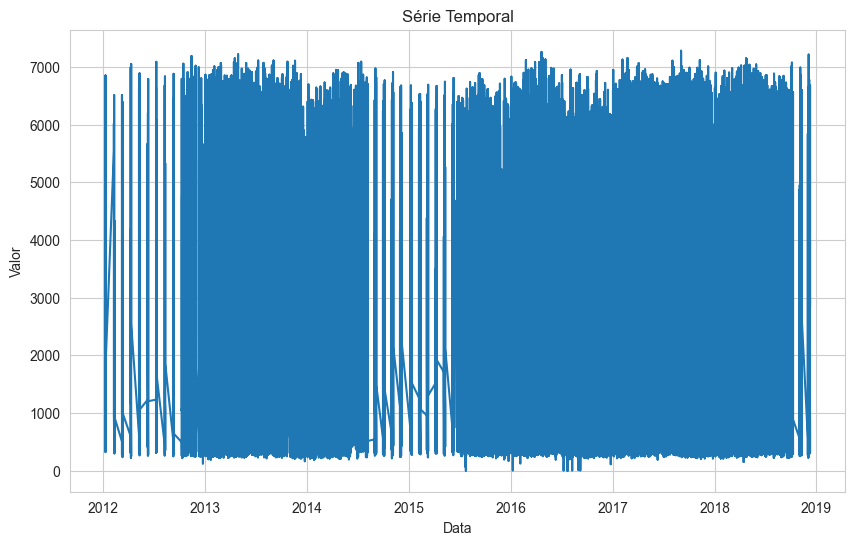

In [128]:
# Visualizando a série temporal
df_serie_temp.index = pd.to_datetime(df_serie_temp.index)

plt.figure(figsize=(10, 6))
plt.plot(df_serie_temp)
plt.title('Série Temporal')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.show()

In [129]:
#verificando se a série temporal é estacionária com base no Teste Dickey-Fuller Aumentado (ADF)
resultado_adf = adfuller(df_serie_temp)

# Imprimindo os resultados
print('Estatística ADF:', resultado_adf[0])
print('Valor-p:', resultado_adf[1])
print('Valores críticos:')
for chave, valor in resultado_adf[4].items():
    print(f'   {chave}: {valor}')

Estatística ADF: -28.09090129989716
Valor-p: 0.0
Valores críticos:
   1%: -3.430485863397371
   5%: -2.8616000487800735
   10%: -2.566801961988572


In [130]:
#Se a estatística ADF for menor que os valores críticos para um nível de significância específico 
#(por exemplo, 0.01, 0.05 ou 0.10), você pode rejeitar a hipótese nula de não estacionariedade 
#e concluir que a série temporal é estacionária
#Neste caso, como a estatística ADF (-28) é muito menor do que o valor crítico (-3), 
#pode-se concluir com confiança que a série temporal é estacionária.

In [131]:
# Dividindo os dados em conjuntos de treinamento e teste (por exemplo, 80% para treinamento, 20% para teste)
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)
#convertendo para tipo array para o treinamento
X_treino_array = X_treino.values.ravel()  # Convertendo para um array unidimensional
y_teste_array = y_teste.values.ravel()    # Convertendo para um array unidimensional
X_teste_array = X_teste.values.ravel()   # Convertendo para um array unidimensional
y_teste_array = y_teste.values.ravel()   # Convertendo para um array unidimensional

In [132]:
# Criar o modelo
modelo_v6 = ARIMA(X_treino_array, order=(5,1,0))

In [133]:
modelo_v6 

In [134]:
# Ajustar o modelo ARIMA aos dados de treinamento
#modelo_arima = ARIMA(X_treino, order=(5,1,0))
modelo_arima_ajustado_v6 = modelo_v6.fit()

# Fazer previsões nos dados de teste
y_pred = modelo_arima_ajustado_v6.forecast(steps=len(X_teste))

# Calculando o RMSE
rmse_6 = np.sqrt(mean_squared_error(y_teste, y_pred))
print("RMSE:", rmse_6)

RMSE: 3358.144056774965


## 8.7 - Modelo de Séries Temporais - LSTM

In [135]:
# Função para preparar os dados para a LSTM
def preparar_dados_para_lstm(serie_temporal, passos_de_tempo):
    X, y = [], []
    for i in range(len(serie_temporal) - passos_de_tempo):
        X.append(serie_temporal[i:(i + passos_de_tempo)])
        y.append(serie_temporal[i + passos_de_tempo])
    return np.array(X), np.array(y)

In [136]:
# Definir o número de passos de tempo
passos_de_tempo = 10
# Preparar os dados para a LSTM
X, y = preparar_dados_para_lstm(df_serie_temp['traffic_volume'], passos_de_tempo)

# Redimensionar os dados para o formato [amostras, passos de tempo, características]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Dividir os dados em conjuntos de treinamento e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, shuffle=False)

# Criar o modelo LSTM
modelo_v7 = Sequential()
modelo_v7.add(LSTM(50, input_shape=(passos_de_tempo, 1)))
modelo_v7.add(Dense(1))
modelo_v7.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
modelo_v7.fit(X_treino, y_treino, epochs=10, batch_size=32)

# Fazer previsões
y_pred = modelo_v7.predict(X_teste)

# Imprimir algumas previsões
print(y_pred[:10])

C:\Users\Chilov\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 14515213.0000
Epoch 2/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 14101632.0000
Epoch 3/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 13890107.0000
Epoch 4/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 13694529.0000
Epoch 5/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 13365287.0000
Epoch 6/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 13199586.0000
Epoch 7/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 12827582.0000
Epoch 8/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 12635863.0000
Epoch 9/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 12286808.0000
Epoch 10/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 12160044.0000
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
[[456.5219 ]
 [456.5219 ]
 [456.5219 ]
 [456.5219 ]
 [456.5219 ]
 [456.5219 ]
 [456.51172]
 [456.43472]
 [456.52167]
 [456.5219 ]]


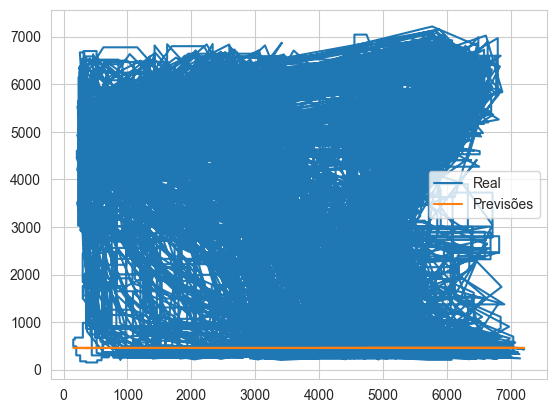

In [137]:
# Visualizar os resultados
plt.plot(X_teste[:,0], y_teste, label='Real')
plt.plot(X_teste[:,0], y_pred, label='Previsões')
plt.legend()
plt.show()

In [138]:
#o algoritmo LSTM não capturou padrão nos dados

In [139]:
# Supondo que `y_true` são os valores reais e `y_pred` são as previsões do modelo
mae_7 = mean_absolute_error(y_teste, y_pred)
print("MAE:", mae_7)
# Calcular o RMSE
rmse_7 = np.sqrt(mean_squared_error(y_teste, y_pred))
print("RMSE:", rmse_7)

MAE: 2822.707280993115
RMSE: 3422.1508876148723


## 8.8 - Modelo de Séries Temporais - FNN

Epoch 1/10


C:\Users\Chilov\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0779
Epoch 2/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0691
Epoch 3/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0690
Epoch 4/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0683
Epoch 5/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0682
Epoch 6/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0680
Epoch 7/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0671
Epoch 8/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0675
Epoch 9/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0671
Epoch 10/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0676
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0631
Loss: 0.0638209655880928
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


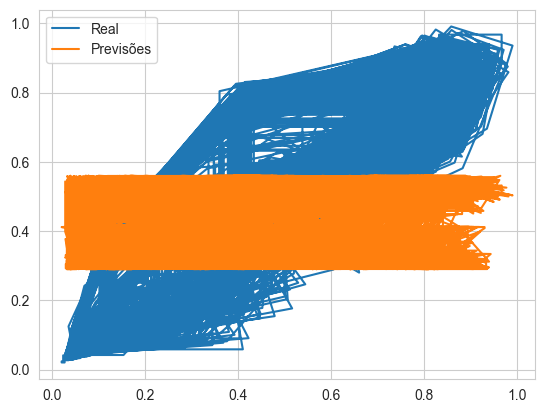

In [140]:
# Normalização dos dados
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df['traffic_volume'].values.reshape(-1, 1))

# Divisão em sequências
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # ajuste conforme necessário
X, y = create_sequences(scaled_data, seq_length)

# Divisão em conjuntos de treinamento e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reformatação dos dados (se necessário)
X_treino = X_treino.reshape(-1, seq_length, 1)
X_teste = X_teste.reshape(-1, seq_length, 1)
# Construir o modelo FNN
#observar que o primeiro número do input_shape deve ser o mesmo do seq_length
modelo_v8 = Sequential([
    Dense(64, activation='relu', input_shape=(10,1)),
    Dense(64, activation='relu'),
    Dense(1)
])

# Compilar o modelo
modelo_v8.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
modelo_v8.fit(X_treino, y_treino, epochs=10, batch_size=32, verbose=1)

# Avaliar o modelo
loss = modelo_v8.evaluate(X_teste, y_teste)
print("Loss:", loss)

# Fazer previsões
y_pred = modelo_v8.predict(X_teste)

# Visualizar os resultados
# Selecionar o último ponto de cada sequência para plotar no eixo x
x_plot = X_teste[:, -1, 0]  

# Selecionar apenas os primeiros valores de y_teste e y_pred para plotar
y_plot = y_teste[:, 0] 
y_pred_plot = y_pred[:, 0] 

# Plotar os valores reais
plt.plot(x_plot, y_plot, label='Real')
# Plotar as previsões
plt.plot(x_plot, y_pred_plot, label='Previsões')
plt.legend()
plt.show()

In [141]:
#redimensionando y
y_reformulado = y[:len(y_pred)]
# Redimensionar y_pred para ter a mesma forma que y_reformulado
y_pred_reformulado = y_pred[:, -1, :]  # Selecionar apenas a última previsão de cada sequência


# Supondo que `y` são os valores reais e `y_pred` são as previsões do modelo
mae_8 = mean_absolute_error(y_reformulado, y_pred_reformulado)
print("MAE:", mae_8)
# Calcular o RMSE
rmse_8 = np.sqrt(mean_squared_error(y_reformulado, y_pred_reformulado))
print("RMSE:", rmse_8)

MAE: 0.2529087409714181
RMSE: 0.29226953115230214


In [142]:
#o algoritmo FNN não capturou padrão nos dados

## 8.9 - Modelo de Séries Temporais - 1D CNN

Epoch 1/10


C:\Users\Chilov\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0263
Epoch 2/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0073
Epoch 3/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0066
Epoch 4/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0063
Epoch 5/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0060
Epoch 6/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0063
Epoch 7/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0061
Epoch 8/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0059
Epoch 9/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0059
Epoch 10/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0057
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0034
Loss: 0.003359844908118248
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


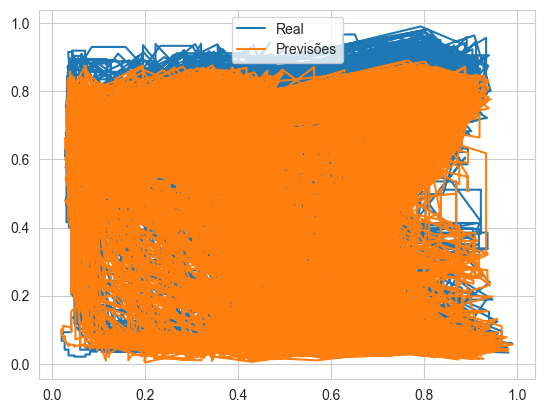

In [143]:
# Normalização dos dados
scaler = MinMaxScaler()
df['traffic_volume_normalized'] = scaler.fit_transform(df[['traffic_volume']])

# Divisão dos dados em sequências
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # ajuste conforme necessário
X, y = create_sequences(df['traffic_volume_normalized'].values, seq_length)

# Divisão dos dados em conjuntos de treinamento e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, shuffle=False)

# Redimensionamento dos dados para 3D
X_treino = np.reshape(X_treino, (X_treino.shape[0], X_treino.shape[1], 1))
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))


# Construir o modelo 1D CNN
modelo_v9 = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
])

# Compilar o modelo
modelo_v9.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
modelo_v9.fit(X_treino, y_treino, epochs=10, batch_size=32, verbose=1)

# Avaliar o modelo
loss = modelo_v9.evaluate(X_teste, y_teste)
print("Loss:", loss)

# Fazer previsões
y_pred = modelo_v9.predict(X_teste)

# Visualizar os resultados
plt.plot(X_teste[:,0], y_teste, label='Real')
plt.plot(X_teste[:,0], y_pred, label='Previsões')
plt.legend()
plt.show()

In [144]:
#redimensionando y
y_reformulado = y[:len(y_pred)]
# Redimensionar y_pred para ter a mesma forma que y_true_reformulado
y_pred_reformulado = y_pred.squeeze()  # Remove a dimensão extra de y_pred


# Supondo que `y_true` são os valores reais e `y_pred` são as previsões do modelo
mae_9 = mean_absolute_error(y_reformulado, y_pred_reformulado)
print("MAE:", mae_9)
# Calcular o RMSE
rmse_9 = np.sqrt(mean_squared_error(y_reformulado, y_pred_reformulado))
print("RMSE:", rmse_9)

MAE: 0.3154027552191197
RMSE: 0.3853059938242588


In [145]:
# bom modelo 

## 8.10 - Modelo de Séries Temporais - TANN

Epoch 1/10


C:\Users\Chilov\anaconda3\lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0908
Epoch 2/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0753
Epoch 3/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0746
Epoch 4/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0754
Epoch 5/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0750
Epoch 6/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0750
Epoch 7/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0750
Epoch 8/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0747
Epoch 9/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0748
Epoch 10/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0750
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0727
Loss: 0.07327903062105179
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


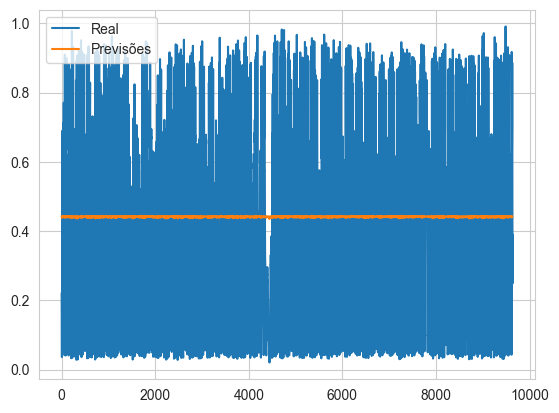

In [146]:
# Supondo que 'df' é o seu DataFrame com a série temporal, onde 'traffic_volume' é a coluna de valores
# Normalização dos dados
scaler = MinMaxScaler()
df['traffic_volume_normalized'] = scaler.fit_transform(df[['traffic_volume']])

# Divisão dos dados em sequências
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # ajuste conforme necessário
X, y = create_sequences(df['traffic_volume_normalized'].values, seq_length)

# Divisão dos dados em conjuntos de treinamento e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, shuffle=False)

# Redimensionamento dos dados para 3D
X_treino = np.reshape(X_treino, (X_treino.shape[0], X_treino.shape[1], 1))
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))

# Construir o modelo TANN
modelo_v10 = Sequential([
    TimeDistributed(Dense(64, activation='relu'), input_shape=(seq_length, 1)),
    Dense(1)  # Camada de saída única para prever a média
])

# Compilar o modelo
modelo_v10.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
modelo_v10.fit(X_treino, y_treino, epochs=10, batch_size=32, verbose=1)

# Avaliar o modelo
loss = modelo_v10.evaluate(X_teste, y_teste)
print("Loss:", loss)

# Fazer previsões
y_pred = modelo_v10.predict(X_teste)

# Visualizar os resultados
import matplotlib.pyplot as plt
# Selecionar a última previsão de cada instância de teste
y_pred_plot = y_pred[:, -1, 0]  # Selecionar apenas a última previsão de cada instância de teste
plt.plot(y_teste, label='Real')
# Plotar as previsões
plt.plot(y_pred_plot, label='Previsões')
plt.legend()
plt.show()

In [147]:
#redimensionando y
y_reformulado = y[:len(y_pred)]
# Selecionar a última previsão de cada instância de teste
y_pred_reformulado = y_pred[:, -1, 0]  # Selecionar apenas a última previsão de cada instância de teste


# Supondo que `y_true` são os valores reais e `y_pred` são as previsões do modelo
mae_10 = mean_absolute_error(y_reformulado, y_pred_reformulado)
print("MAE:", mae_10)
# Calcular o RMSE
rmse_10 = np.sqrt(mean_squared_error(y_reformulado, y_pred_reformulado))
print("RMSE:", rmse_10)

MAE: 0.24454050666677205
RMSE: 0.2781357115256738


In [148]:
#o algoritmo TANN não capturou padrão nos dados

## 8.11 - Avaliação do melhor algoritmo

In [149]:
# Defina os valores para cada modelo
modelos = ['Regressão Linear Múltipla', 'Random Forest', 'Rede Neural', 'XGBoost', 'LightGBM', 'ARIMA','LSTM','FNN','CNN','TANN']
evs = [evs_1, evs_2, evs_3, evs_4, evs_5, 0, 0, 0, 0, 0]
mae = [mae_1, mae_2, mae_3, mae_4, mae_5, 0, mae_7, mae_8, mae_9, mae_10]
mse = [mse_1, mse_2, mse_3, mse_4, mse_5, 0, 0, 0, 0, 0]
rmse = [rmse_1, rmse_2, rmse_3, rmse_4, rmse_5, rmse_6, rmse_7, rmse_8, rmse_9, rmse_10]
r2 = [r2_1, r2_2, r2_3, r2_4, r2_5, 0, 0, 0, 0, 0]


# Crie um DataFrame usando Pandas
df_resumo_modelos = pd.DataFrame({
    'Modelo': modelos,
    'EVS': evs,
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse,
    'R2': r2,
    })

# Exiba o DataFrame
df_resumo_modelos.index += 1
df_resumo_modelos_R2 = df_resumo_modelos.sort_values(by='R2', ascending=False)
print("                               Avaliação do modelos com base no R2\n")
print(df_resumo_modelos_R2.to_string(index=True))
#print(df_resumo_modelos.to_string(index=False))

                               Avaliação do modelos com base no R2

                       Modelo       EVS          MAE           MSE         RMSE        R2
4                     XGBoost  0.783849   633.468898  8.540902e+05   924.170014  0.783849
5                    LightGBM  0.783676   634.131415  8.547751e+05   924.540503  0.783676
3                 Rede Neural  0.781960   630.955741  8.619052e+05   928.388511  0.781871
2               Random Forest  0.747743   704.333199  9.967572e+05   998.377261  0.747743
1   Regressão Linear Múltipla  0.130539  1637.475059  3.435785e+06  1853.586954  0.130480
6                       ARIMA  0.000000     0.000000  0.000000e+00  3358.144057  0.000000
7                        LSTM  0.000000  2822.707281  0.000000e+00  3422.150888  0.000000
8                         FNN  0.000000     0.252909  0.000000e+00     0.292270  0.000000
9                         CNN  0.000000     0.315403  0.000000e+00     0.385306  0.000000
10                       TANN  0

In [150]:
df_resumo_modelos_evs = df_resumo_modelos.sort_values(by='EVS', ascending=False)
print("                              Avaliação do modelos com base no EVS\n")
print(df_resumo_modelos_evs.to_string(index=True))

                              Avaliação do modelos com base no EVS

                       Modelo       EVS          MAE           MSE         RMSE        R2
4                     XGBoost  0.783849   633.468898  8.540902e+05   924.170014  0.783849
5                    LightGBM  0.783676   634.131415  8.547751e+05   924.540503  0.783676
3                 Rede Neural  0.781960   630.955741  8.619052e+05   928.388511  0.781871
2               Random Forest  0.747743   704.333199  9.967572e+05   998.377261  0.747743
1   Regressão Linear Múltipla  0.130539  1637.475059  3.435785e+06  1853.586954  0.130480
6                       ARIMA  0.000000     0.000000  0.000000e+00  3358.144057  0.000000
7                        LSTM  0.000000  2822.707281  0.000000e+00  3422.150888  0.000000
8                         FNN  0.000000     0.252909  0.000000e+00     0.292270  0.000000
9                         CNN  0.000000     0.315403  0.000000e+00     0.385306  0.000000
10                       TANN  0

In [151]:
df_resumo_modelos_rmse = df_resumo_modelos.sort_values(by='RMSE', ascending=True)
print("                              Avaliação do modelos com base no RMSE\n")
print(df_resumo_modelos_rmse.to_string(index=True))

                              Avaliação do modelos com base no RMSE

                       Modelo       EVS          MAE           MSE         RMSE        R2
10                       TANN  0.000000     0.244541  0.000000e+00     0.278136  0.000000
8                         FNN  0.000000     0.252909  0.000000e+00     0.292270  0.000000
9                         CNN  0.000000     0.315403  0.000000e+00     0.385306  0.000000
4                     XGBoost  0.783849   633.468898  8.540902e+05   924.170014  0.783849
5                    LightGBM  0.783676   634.131415  8.547751e+05   924.540503  0.783676
3                 Rede Neural  0.781960   630.955741  8.619052e+05   928.388511  0.781871
2               Random Forest  0.747743   704.333199  9.967572e+05   998.377261  0.747743
1   Regressão Linear Múltipla  0.130539  1637.475059  3.435785e+06  1853.586954  0.130480
6                       ARIMA  0.000000     0.000000  0.000000e+00  3358.144057  0.000000
7                        LSTM  

## Seleção do Modelo

#### O melhor modelo é o v_9. Então seguiremos com o modelo_v9 1D CNN

## 8.12 - Otimização do modelo

### 8.12.1 - Otimização somente com mudança de hiperparâmetro - alterando kernel_size

Epoch 1/10


C:\Users\Chilov\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0371
Epoch 2/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0159
Epoch 3/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0139
Epoch 4/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0129
Epoch 5/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0123
Epoch 6/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0123
Epoch 7/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0118
Epoch 8/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0119
Epoch 9/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0114
Epoch 10/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0113
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079
Loss: 0.00763642368838191
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


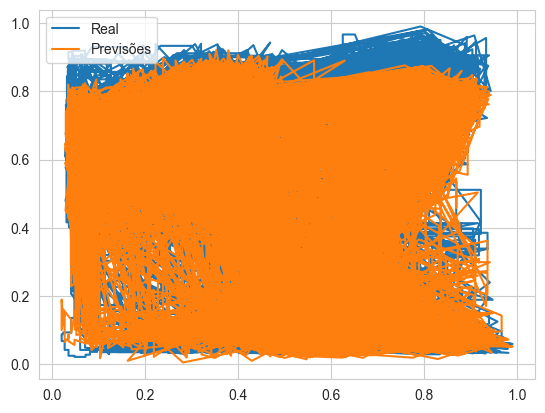

In [152]:
# Normalização dos dados
scaler = MinMaxScaler()
df['traffic_volume_normalized'] = scaler.fit_transform(df[['traffic_volume']])

# Divisão dos dados em sequências
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # ajuste conforme necessário
X, y = create_sequences(df['traffic_volume_normalized'].values, seq_length)

# Divisão dos dados em conjuntos de treinamento e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, shuffle=False)

# Redimensionamento dos dados para 3D
X_treino = np.reshape(X_treino, (X_treino.shape[0], X_treino.shape[1], 1))
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))


# Construir o modelo 1D CNN
modelo_v11 = Sequential([
    Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(seq_length, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
])

# Compilar o modelo
modelo_v11.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
modelo_v11.fit(X_treino, y_treino, epochs=10, batch_size=32, verbose=1)

# Avaliar o modelo
loss = modelo_v11.evaluate(X_teste, y_teste)
print("Loss:", loss)

# Fazer previsões
y_pred = modelo_v11.predict(X_teste)

# Visualizar os resultados
plt.plot(X_teste[:,0], y_teste, label='Real')
plt.plot(X_teste[:,0], y_pred, label='Previsões')
plt.legend()
plt.show()

In [153]:
#redimensionando y
y_reformulado = y[:len(y_pred)]
# Redimensionar y_pred para ter a mesma forma que y_true_reformulado
y_pred_reformulado = y_pred.squeeze()  # Remove a dimensão extra de y_pred


# Supondo que `y_true` são os valores reais e `y_pred` são as previsões do modelo
mae_11 = mean_absolute_error(y_reformulado, y_pred_reformulado)
print("MAE:", mae_11)
# Calcular o RMSE
rmse_11 = np.sqrt(mean_squared_error(y_reformulado, y_pred_reformulado))
print("RMSE:", rmse_11)

MAE: 0.30732144461489064
RMSE: 0.37487337676039667


In [154]:
# após testes, verificou-se que o melhor kernel_size é 4.

### 8.12.2 - Otimização alterando o pool_size

Epoch 1/10


C:\Users\Chilov\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0616
Epoch 2/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0324
Epoch 3/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0272
Epoch 4/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0258
Epoch 5/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0253
Epoch 6/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0251
Epoch 7/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0249
Epoch 8/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0238
Epoch 9/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0235
Epoch 10/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0234
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0162
Loss: 0.015724292024970055
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


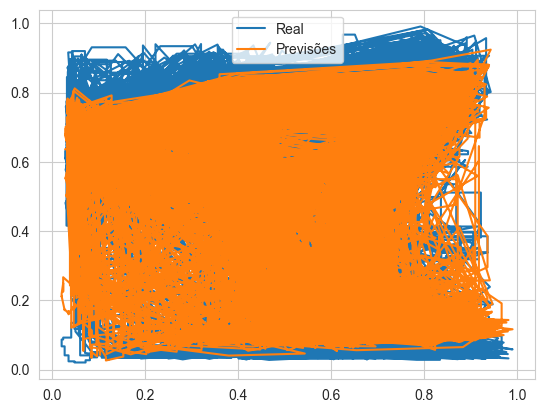

In [155]:
# Normalização dos dados
scaler = MinMaxScaler()
df['traffic_volume_normalized'] = scaler.fit_transform(df[['traffic_volume']])

# Divisão dos dados em sequências
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # ajuste conforme necessário
X, y = create_sequences(df['traffic_volume_normalized'].values, seq_length)

# Divisão dos dados em conjuntos de treinamento e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, shuffle=False)

# Redimensionamento dos dados para 3D
X_treino = np.reshape(X_treino, (X_treino.shape[0], X_treino.shape[1], 1))
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))


# Construir o modelo 1D CNN
modelo_v12 = Sequential([
    Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(seq_length, 1)),
    MaxPooling1D(pool_size=4),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
])

# Compilar o modelo
modelo_v12.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
modelo_v12.fit(X_treino, y_treino, epochs=10, batch_size=32, verbose=1)

# Avaliar o modelo
loss = modelo_v12.evaluate(X_teste, y_teste)
print("Loss:", loss)

# Fazer previsões
y_pred = modelo_v12.predict(X_teste)

# Visualizar os resultados
plt.plot(X_teste[:,0], y_teste, label='Real')
plt.plot(X_teste[:,0], y_pred, label='Previsões')
plt.legend()
plt.show()

In [156]:
#redimensionando y
y_reformulado = y[:len(y_pred)]
# Redimensionar y_pred para ter a mesma forma que y_true_reformulado
y_pred_reformulado = y_pred.squeeze()  # Remove a dimensão extra de y_pred


# Supondo que `y_true` são os valores reais e `y_pred` são as previsões do modelo
mae_12 = mean_absolute_error(y_reformulado, y_pred_reformulado)
print("MAE:", mae_12)
# Calcular o RMSE
rmse_12 = np.sqrt(mean_squared_error(y_reformulado, y_pred_reformulado))
print("RMSE:", rmse_12)

MAE: 0.29687754086710577
RMSE: 0.35995624219990624


In [157]:
# após testes, verificou-se que o melhor pool_size é 4.

## 8.12.3 - Otimização alterando o batch_size

Epoch 1/10


C:\Users\Chilov\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1420
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0637
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0553
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0515
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0478
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0432
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0395
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0369
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0355
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0345
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0272
Loss: 0.027661213651299477
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


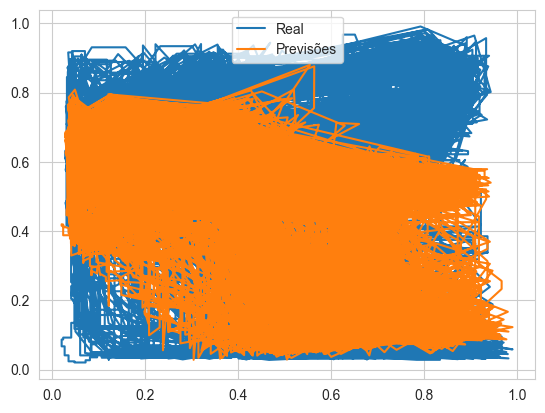

In [158]:
# Normalização dos dados
scaler = MinMaxScaler()
df['traffic_volume_normalized'] = scaler.fit_transform(df[['traffic_volume']])

# Divisão dos dados em sequências
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # ajuste conforme necessário
X, y = create_sequences(df['traffic_volume_normalized'].values, seq_length)

# Divisão dos dados em conjuntos de treinamento e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, shuffle=False)

# Redimensionamento dos dados para 3D
X_treino = np.reshape(X_treino, (X_treino.shape[0], X_treino.shape[1], 1))
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))


# Construir o modelo 1D CNN
modelo_v13 = Sequential([
    Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(seq_length, 1)),
    MaxPooling1D(pool_size=4),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
])

# Compilar o modelo
modelo_v13.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
modelo_v13.fit(X_treino, y_treino, epochs=10, batch_size=1024, verbose=1)

# Avaliar o modelo
loss = modelo_v13.evaluate(X_teste, y_teste)
print("Loss:", loss)

# Fazer previsões
y_pred = modelo_v13.predict(X_teste)

# Visualizar os resultados
plt.plot(X_teste[:,0], y_teste, label='Real')
plt.plot(X_teste[:,0], y_pred, label='Previsões')
plt.legend()
plt.show()

In [159]:
#redimensionando y
y_reformulado = y[:len(y_pred)]
# Redimensionar y_pred para ter a mesma forma que y_true_reformulado
y_pred_reformulado = y_pred.squeeze()  # Remove a dimensão extra de y_pred


# Supondo que `y_true` são os valores reais e `y_pred` são as previsões do modelo
mae_13 = mean_absolute_error(y_reformulado, y_pred_reformulado)
print("MAE:", mae_13)
# Calcular o RMSE
rmse_13 = np.sqrt(mean_squared_error(y_reformulado, y_pred_reformulado))
print("RMSE:", rmse_13)

MAE: 0.2820397868846037
RMSE: 0.33939741550522284


In [160]:
# após testes, verificou-se que o melhor batch_size é 32. Valores maiores diminuem o RMSE mas perdem o padrão no modelo

## 8.12.4 - Otimização alterando o epochs

Epoch 1/10


C:\Users\Chilov\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0665
Epoch 2/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0319
Epoch 3/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0276
Epoch 4/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0267
Epoch 5/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0254
Epoch 6/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0254
Epoch 7/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0247
Epoch 8/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0242
Epoch 9/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0237
Epoch 10/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0236
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0166
Loss: 0.016079220920801163
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


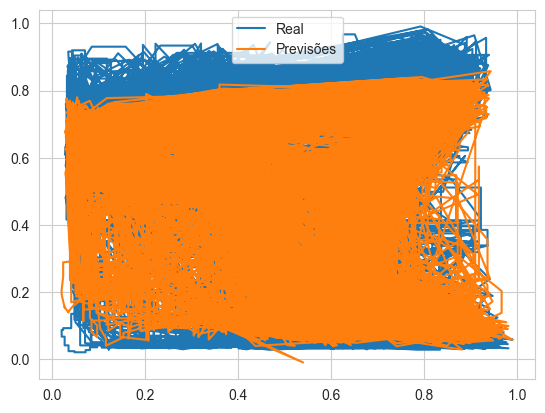

In [161]:
# Normalização dos dados
scaler = MinMaxScaler()
df['traffic_volume_normalized'] = scaler.fit_transform(df[['traffic_volume']])

# Divisão dos dados em sequências
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # ajuste conforme necessário
X, y = create_sequences(df['traffic_volume_normalized'].values, seq_length)

# Divisão dos dados em conjuntos de treinamento e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, shuffle=False)

# Redimensionamento dos dados para 3D
X_treino = np.reshape(X_treino, (X_treino.shape[0], X_treino.shape[1], 1))
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))


# Construir o modelo 1D CNN
modelo_v14 = Sequential([
    Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(seq_length, 1)),
    MaxPooling1D(pool_size=4),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
])

# Compilar o modelo
modelo_v14.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
modelo_v14.fit(X_treino, y_treino, epochs=10, batch_size=32, verbose=1)

# Avaliar o modelo
loss = modelo_v14.evaluate(X_teste, y_teste)
print("Loss:", loss)

# Fazer previsões
y_pred = modelo_v14.predict(X_teste)

# Visualizar os resultados
plt.plot(X_teste[:,0], y_teste, label='Real')
plt.plot(X_teste[:,0], y_pred, label='Previsões')
plt.legend()
plt.show()

In [162]:
#redimensionando y
y_reformulado = y[:len(y_pred)]
# Redimensionar y_pred para ter a mesma forma que y_true_reformulado
y_pred_reformulado = y_pred.squeeze()  # Remove a dimensão extra de y_pred


# Supondo que `y_true` são os valores reais e `y_pred` são as previsões do modelo
mae_14 = mean_absolute_error(y_reformulado, y_pred_reformulado)
print("MAE:", mae_14)
# Calcular o RMSE
rmse_14 = np.sqrt(mean_squared_error(y_reformulado, y_pred_reformulado))
print("RMSE:", rmse_14)

MAE: 0.29537572847584115
RMSE: 0.3581548739002708


In [163]:
# após testes, verificou-se que o melhor epochs é 10.

In [164]:
# assim, utilizamos o modelo v_14 como final.

## 8.13 - Utilizando o modelo escolhido para previsões futuras

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

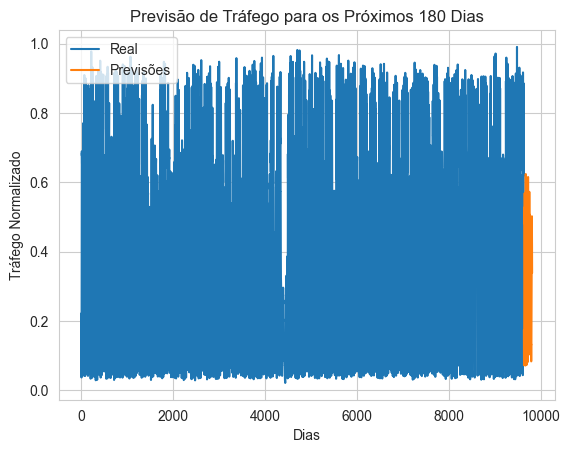

In [165]:
# para finalizar vamos fazer a previsão do volume de tráfego para os próximos 6 meses (180 dias)
# Definir o número de dias para prever
dias_para_prever = 180

# Copiar o último conjunto de dados de teste para iniciar a previsão
ultimo_x = X_teste[-1]

# Lista para armazenar as previsões
previsoes = []

# Fazer as previsões para os próximos dias
for _ in range(dias_para_prever):
    # Prever o próximo ponto no tempo
    proxima_predicao = modelo_v14.predict(ultimo_x.reshape(1, seq_length, 1))
    # Adicionar a previsão à lista de previsões
    previsoes.append(proxima_predicao[0, 0])
    # Atualizar os dados de entrada para a próxima iteração, descartando o primeiro ponto e adicionando a previsão mais recente
    ultimo_x = np.append(ultimo_x[1:, :], proxima_predicao, axis=0)

# Visualizar as previsões
plt.plot(y_teste, label='Real')  # Plotar os últimos dados reais
plt.plot(range(len(y_teste), len(y_teste) + dias_para_prever), previsoes, label='Previsões')  # Plotar as previsões
plt.legend()
plt.title('Previsão de Tráfego para os Próximos 180 Dias')
plt.xlabel('Dias')
plt.ylabel('Tráfego Normalizado')
plt.show()

In [166]:
#como a visualização está ruim, vamos observarapenas os últimos 2000 dias e os 60 novos dias previstos

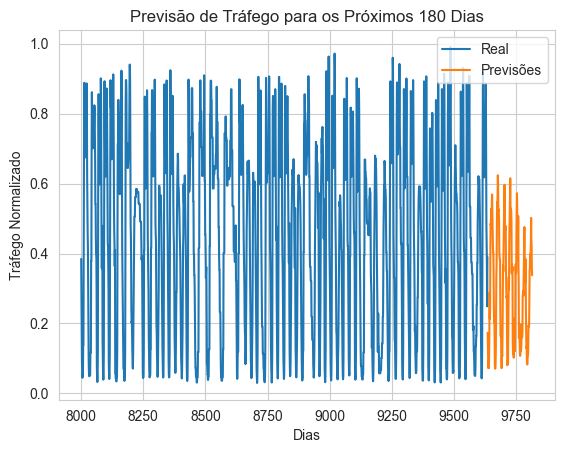

In [167]:
# Ajustar os índices para plotar apenas a partir de 8000
inicio = 8000
fim = inicio + dias_para_prever

# Visualizar as previsões
plt.plot(range(inicio, len(y_teste)), y_teste[inicio:], label='Real')  # Plotar os últimos dados reais
plt.plot(range(len(y_teste), len(y_teste) + dias_para_prever), previsoes, label='Previsões')  # Plotar as previsões
plt.legend()
plt.title('Previsão de Tráfego para os Próximos 180 Dias')
plt.xlabel('Dias')
plt.ylabel('Tráfego Normalizado')
plt.show()

# Conclusão

## O melhor modelo foi o v14 com RMSE de apenas 0.359.

# Fim